In [163]:
import numpy as np
import pandas as pd
from sklearn.cluster import AgglomerativeClustering, DBSCAN, KMeans
from sklearn.metrics import silhouette_score
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns

datapath = '../data/'
penguins = pd.read_csv(datapath + "penguins.csv")

In [263]:
## data exploration
penguins.head(10)
penguins['species'].unique()
penguins['species'].value_counts()

# check missing values
#print(np.sum(penguins.isnull(),axis=0))

# drop the rows with missing data
print(penguins.shape)
penguins_subset = penguins.dropna(axis=0) 
print(penguins_subset.shape)
np.sum(np.sum(penguins_subset.isnull(),axis=0)) # if this equals 0, no missing value in the data now

# Convert `sex` column from categorical to numeric.
penguins_subset['sex'] = penguins_subset['sex'].str.upper()
penguins_subset = pd.get_dummies(penguins_subset, columns=['sex'], drop_first=True)
penguins_subset = penguins_subset.drop('island', axis=1)
penguins_subset.head(10)

X = penguins_subset.drop('species', axis=1)

(344, 7)
(333, 7)


C:\Users\hychy\AppData\Local\Temp\ipykernel_68692\897250814.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  penguins_subset['sex'] = penguins_subset['sex'].str.upper()


,species,bill_length_mm,bill_depth_mm,flipper_length_mm,body_mass_g,sex_MALE
0,Adelie,39.1,18.7,181.0,3750.0,True
1,Adelie,39.5,17.4,186.0,3800.0,False
2,Adelie,40.3,18.0,195.0,3250.0,False
4,Adelie,36.7,19.3,193.0,3450.0,False
5,Adelie,39.3,20.6,190.0,3650.0,True
6,Adelie,38.9,17.8,181.0,3625.0,False
7,Adelie,39.2,19.6,195.0,4675.0,True
12,Adelie,41.1,17.6,182.0,3200.0,False
13,Adelie,38.6,21.2,191.0,3800.0,True
14,Adelie,34.6,21.1,198.0,4400.0,True


In [ ]:
## Use Kmeans to cluster

# split data
scaler_ = StandardScaler()
dir(scaler_)
X_scaled = scaler_.fit_transform(X)
X_scaled

# Try different values of k=2 to 10
kvals = range(2,11)
def GridSearchKMeans(ks, X):
    inertias = []
    sil_scores = []
    for k in ks:
        kms = KMeans(n_clusters=k, random_state=42)
        kms_fit = kms.fit(X)
        inertias.append(kms_fit.inertia_)
        sil_scores.append(silhouette_score(X, kms_fit.labels_))
    return inertias, sil_scores

inertia_vals, sil_score_vals = GridSearchKMeans(kvals, X_scaled)

# Visualize results
dt0 = pd.DataFrame({'k': kvals, 'inertia': inertia_vals, 'silhouette score': sil_score_vals})
dfplt = pd.melt(dt0, id_vars=['k'], value_vars=['inertia', 'silhouette score'], var_name='metrics')
plt.figure()
plot = sns.lineplot(data=dfplt, x='k', y='value', hue='metrics')
plot.set_xlabel("# of clusters")
plot.set_ylabel("Metrics")
plt.show()

# Use the optimal k value to fit the model
km = KMeans(n_clusters=6, random_state=42)
km_labels = km.fit(X_scaled).labels_
np.unique(km_labels)

# attach the results from the optimal model to the dataframe:
penguins_subset['cluster'] = km_labels
plt.figure()
penguins_subset.groupby(by=['cluster', 'species']).size().plot.bar(title='Clusters differentiated by species',
                                                                   figsize=(6, 5),
                                                                   ylabel='Size',
                                                                   xlabel='(Cluster, Species)');
penguins_subset.groupby(by=['cluster', 'species', 'sex_MALE']).size().plot.bar(title='Clusters differentiated by species and sex',
                                                                   figsize=(6, 5),
                                                                   ylabel='Size',
                                                                   xlabel='(Cluster, Species, sex_MALE)');
penguins_subset.groupby(by=['cluster','species','sex_MALE']).size().unstack(level = 'species', fill_value=0).plot.bar(title='Clusters differentiated by species and sex',
                                                                                                                      figsize=(6, 5),
                                                                                                                      ylabel='Size',
                                                                                                                      xlabel='(Cluster, Sex)')
plt.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()

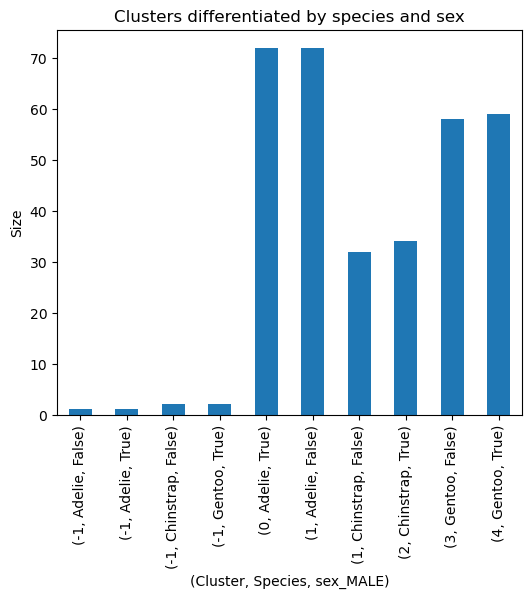

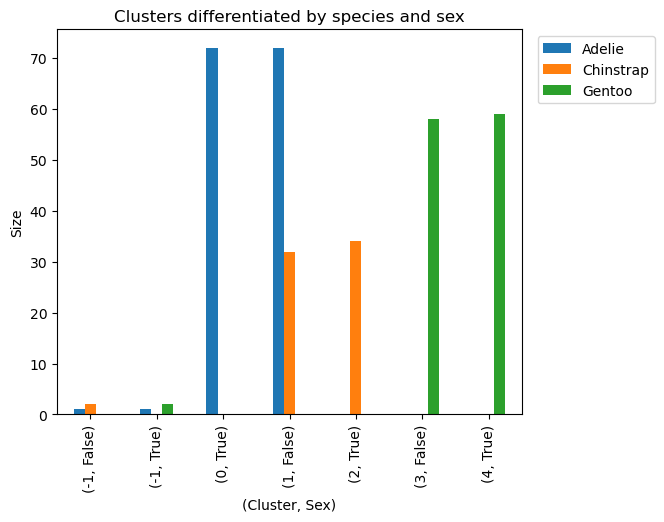

In [261]:
## Now clustering using DBSCAN

# Scale data:
scaler_ = StandardScaler()
dir(scaler_)
X_scaled = scaler_.fit_transform(X)
X_scaled

grids = {'eps': [0.76, 0.765, 0.77, 0.775, 0.78, 0.785, 0.79, 0.795, 0.8], 'min_sample': [3, 4, 5]}
def GridSearchDBSCAN(grids, X):
    eps_vals = grids['eps']
    minsample_vals = grids['min_sample']
    param_combos = []
    sil_scores = []
    for epsi in eps_vals:
        for minsp in minsample_vals:
            param_combos.append((epsi, minsp))
            #print( param_combos[-1] )
            dbs = DBSCAN(eps=epsi, min_samples=minsp)
            dbs_fit = dbs.fit(X)
            sil_scores.append(silhouette_score(X, dbs_fit.labels_))
            #print(dbs_fit.labels_)
    return sil_scores, param_combos

sil_scores, param_combos = GridSearchDBSCAN(grids, X_scaled)
best_params_ = np.array(param_combos)[(sil_scores == np.max(sil_scores))][0,]
dbs = DBSCAN(eps=best_params_[0], min_samples=best_params_[1].astype(int))
dbs_fit = dbs.fit(X_scaled)
dbs_labels = dbs_fit.labels_

penguins_subset['cluster'] = dbs_labels
plt.figure()
penguins_subset.groupby(by=['cluster', 'species', 'sex_MALE']).size().plot.bar(title='Clusters differentiated by species and sex',
                                                                   figsize=(6, 5),
                                                                   ylabel='Size',
                                                                   xlabel='(Cluster, Species, sex_MALE)');
penguins_subset.groupby(by=['cluster','species','sex_MALE']).size().unstack(level = 'species', fill_value=0).plot.bar(title='Clusters differentiated by species and sex',
                                                                                                                      figsize=(6, 5),
                                                                                                                      ylabel='Size',
                                                                                                                      xlabel='(Cluster, Sex)')
plt.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()


(6, 'ward')


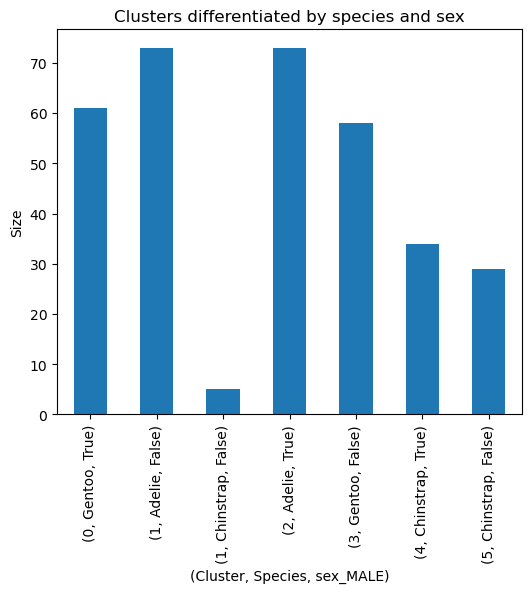

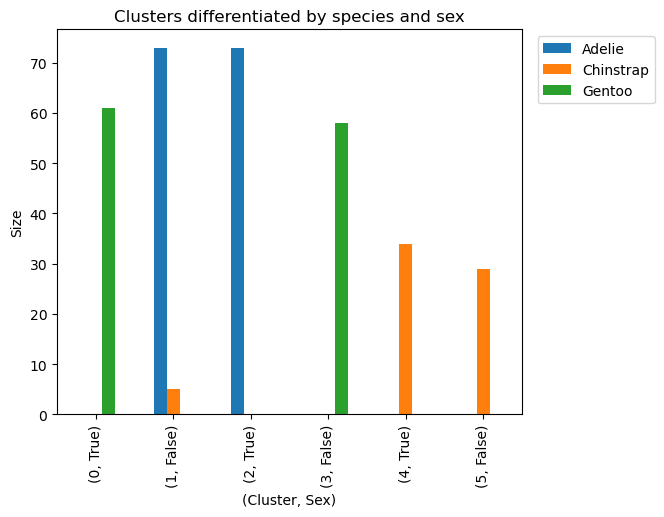

In [347]:
## Now clustering using Agglomerative Clustering

# Scale data:
scaler_ = StandardScaler()
dir(scaler_)
X_scaled = scaler_.fit_transform(X)
X_scaled

grids = {'k': [3,4,5,6,7,8,9], 'linkage': ['ward','average','single','complete']}
def GridSearchAgglomerative(grids, X):
    kvals = grids['k']
    linkages = grids['linkage']
    param_combos = []
    sil_scores = []
    for k, linkage in [(i,j) for i in kvals for j in linkages]:
        param_combos.append((k, linkage))
        agm = AgglomerativeClustering(n_clusters=k, linkage=linkage)
        agm_fit = agm.fit(X)
        sil_scores.append(silhouette_score(X, agm_fit.labels_))
    return param_combos, sil_scores
        
param_combos, sil_scores = GridSearchAgglomerative(grids, X_scaled)
idx_max = [idx for idx in range(len(sil_scores)) if sil_scores[idx] == np.max(sil_scores)]
best_params_ = param_combos[idx_max[0]]
print(best_params_)
agm = AgglomerativeClustering(n_clusters=best_params_[0], linkage=best_params_[1])
agm_fit = agm.fit(X_scaled)
agm_labels = agm_fit.labels_

penguins_subset['cluster'] = agm_labels
plt.figure()
penguins_subset.groupby(by=['cluster', 'species', 'sex_MALE']).size().plot.bar(title='Clusters differentiated by species and sex',
                                                                   figsize=(6, 5),
                                                                   ylabel='Size',
                                                                   xlabel='(Cluster, Species, sex_MALE)');
penguins_subset.groupby(by=['cluster','species','sex_MALE']).size().unstack(level='species', fill_value=0).plot.bar(title='Clusters differentiated by species and sex',
                                                                                                                      figsize=(6, 5),
                                                                                                                      ylabel='Size',
                                                                                                                      xlabel='(Cluster, Sex)')
plt.legend(bbox_to_anchor=(1.3, 1.0))
plt.show()